# TP1: recommandations par filtres collaboratifs utilisateur-utilisateur et item-item.

Boisvenue, Étienne (1798942)

Pigeon, Élisa (1970583)


LOG6308: Systèmes de recommandations

Jeudi 3 octobre, A2019


**Mise en contexte:** 
On nous demande, selon plusieurs approches différentes, d'émettre des recommandations de films pour certains utilisateurs. Les données proviennent de *GroupLens*. Ce jeux de données est habituellement un des premiers jeux de données permettant aux gens de s'initier aux systèmes de recommandations. Ce qui nous est demandé est donc un exercice classique pour mettre en application les techniques collaboratives. C'est le *Hello World* des systèmes de recomandations. 
 
**Données:**
Trois fichiers de données nous sont fournis, soient *u.data*, *u.item.csv* et *u.user.csv*. 
Ils contiennent respectivement 100 000 votes associés à des utilisateur, des données sur les films et des données sur les utilisateurs.

## Importation des modules pertinents

In [2]:
# Importation de librairies
library(Matrix)
library(dplyr)
install.packages("Metrics")
library(Metrics)
# Retrait de l'affichage des avertissements
options(warn=-1)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



package 'Metrics' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\etien\AppData\Local\Temp\RtmpKUnH8D\downloaded_packages


## Fonctions utiles

In [3]:
# Retourne la similitude en cosinus entre un vecteur v et une matrice m
cosinus.vm <- function(v,m) { n <- sqrt(colSums(m^2)); (v %*% m)/(n * sqrt(sum(v^2))) }

# Retourne les positions (index) des n valeur maximales dans la matrice m
max.nindex <- function(m, n=5) {
    i <- order(m, decreasing=TRUE)
    return(i[1:n])
}

# Retourne les positions (index) des n valeurs minimales dans la matrice m
min.nindex <- function(m, n=5) {
    i <- order(m)
    return(i[1:n])
}

## Importation des données

In [1]:
# Les fichiers u.user, u.data et u.item doivent se trouver dans le même path que ce notebook.
(getwd())

# Création de data.frame à partir de ces fichiers .csv
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)

# Création de la matrice creuse (sparse) de vote. Une ligne par utilisateur et une colonne par film
# On agrège les données de u.data par utilisateur
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')

# Inspection des types des objets
(class(u.user))
(class(u.item))
(class(u.data))
(class(m.sparse))


[1] "C:/Users/etien/Documents/poly_maitrise/LOG6308 - Systemes de reccomandations/TP1/TP1_1970583_1798942"

ERROR: Error in sparseMatrix(u.data[, 1], u.data[, 2], x = u.data[, 3]): could not find function "sparseMatrix"


## Brève exploration des données (statistiques descriptives)
Exploration initiale de l'ensemble de données. Le but est simplement de se familiariser avec l'ensemble de données pour mieux le comprendre et être capable de trouver la valeur que l'on pourrait en retirer.

Explorons les différents attributs, la distribution des attributs et essayons d'avoir quelques *insights* initiaux. 

In [5]:
# u.user
('u.user head')
head(u.user)
('u.user summary')
summary(u.user)

# u.item
('u.item head')
head(u.item)
('u.item summary')
summary(u.item)

# u.data
('u.data head')
head(u.data)
('u.data summary')
summary(u.data)

# m.sparse
('m.sparse head')
(m.sparse[1:5,1:5])

[1] "u.user head"

id,age,gender,job,zip
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213
6,42,M,executive,98101


[1] "u.user summary"

       id             age        gender             job           zip     
 Min.   :  1.0   Min.   : 7.00   F:273   student      :196   55414  :  9  
 1st Qu.:236.5   1st Qu.:25.00   M:670   other        :105   55105  :  6  
 Median :472.0   Median :31.00           educator     : 95   10003  :  5  
 Mean   :472.0   Mean   :34.05           administrator: 79   20009  :  5  
 3rd Qu.:707.5   3rd Qu.:43.00           engineer     : 67   55337  :  5  
 Max.   :943.0   Max.   :73.00           programmer   : 66   27514  :  4  
                                         (Other)      :335   (Other):909  

[1] "u.item head"

movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children.s,...,Fantasy,Film.Noir,Horror,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western
1,Toy Story (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),01-Jan-1995,NA,http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] "u.item summary"

    movie.id                              movie.title        release.date
 Min.   :   1.0   Body Snatchers (1993)         :   2   01-Jan-1995:215  
 1st Qu.: 421.2   Butcher Boy, The (1998)       :   2   01-Jan-1994:213  
 Median : 841.5   Chairman of the Board (1998)  :   2   01-Jan-1993:126  
 Mean   : 841.5   Chasing Amy (1997)            :   2   01-Jan-1997: 98  
 3rd Qu.:1261.8   Deceiver (1997)               :   2   01-Jan-1992: 37  
 Max.   :1682.0   Designated Mourner, The (1997):   2   01-Jan-1996: 26  
                  (Other)                       :1670   (Other)    :967  
 video.release.date
 Mode:logical      
 NA's:1682         
                   
                   
                   
                   
                   
                                                                        IMDb.URL   
                                                                            :   3  
 http://us.imdb.com/M/title-exact?Body%20Snatchers%20(1993)                 :   

[1] "u.data head"

user.id,item.id,rating,timestamp
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596
298,474,4,884182806


[1] "u.data summary"

    user.id         item.id           rating       timestamp        
 Min.   :  1.0   Min.   :   1.0   Min.   :1.00   Min.   :874724710  
 1st Qu.:254.0   1st Qu.: 175.0   1st Qu.:3.00   1st Qu.:879448710  
 Median :447.0   Median : 322.0   Median :4.00   Median :882826944  
 Mean   :462.5   Mean   : 425.5   Mean   :3.53   Mean   :883528851  
 3rd Qu.:682.0   3rd Qu.: 631.0   3rd Qu.:4.00   3rd Qu.:888259984  
 Max.   :943.0   Max.   :1682.0   Max.   :5.00   Max.   :893286638  

[1] "m.sparse head"

5 x 5 sparse Matrix of class "dgCMatrix"
   i1 i2 i3 i4 i5
u1  5  3  4  3  3
u2  4  .  .  .  .
u3  .  .  .  .  .
u4  .  .  .  .  .
u5  4  3  .  .  .

In [6]:
unique(u.user$job)

[1] technician    other         writer        executive     administrator
 [6] student       lawyer        educator      scientist     entertainment
[11] programmer    librarian     homemaker     artist        engineer     
[16] marketing     none          healthcare    retired       salesman     
[21] doctor       
21 Levels: administrator artist doctor educator engineer ... writer

On peut donc observer les différentes variables que nous avons dans chacun des data.frame.

**u.user**:
- id: l'identifiant unique de l'utilisateur (integer)
- age: l'âge de l'utilisateur (integer)
- gender: le sexe de l'utilisateur (string/factor, soit M ou F)
- job: l'occupation de l'utilisateur (string/factor)
- zip: le code postal de l'utilisateur (string/factor)

L'âge moyen des utilisateurs est de 34 ans, il y a 943 utilisateurs uniques, 670 hommes et 273 femmes (*imbalance dataset*, donc potentiellement que nous serons meilleur pour reccomander des films aux hommes qu'aux femmes), 196 étudiants, 105 dont l'occupation n'est pas catégorisé (other) et 95 éducateurs.

**u.item**:
- movie.id: l'identifiant unique du film (integer)
- movie.title: le titre du film (string/factor)
- release.date: la date de sortie du film (string/factor)
- IMDb.URL: l'addresse URL du film dans la base de données IMDB (Internet Movie DataBase) (factor/string)
- unknown/Action/Adventure/Animation/Children.s/Fantasy...: Une série de variable *OneHotEncoded* qui représente le genre du film (integer). Il y a 19 genres possibles.

Il y a 1682 films unique et le genre de film le plus présent dans la base de données est ceux de type *Drama*. Il y a autant de *Thriller* que de films de *Action*. Le genre le moins présent est *Unknown*, ce qui est bien. Nous désirons avoir le moins d'informations inconnues possible. On peut déduire tout ceci en regardant les moyennes des variables *OneHotEncoded*.

**u.data**:
- user.id: l'identifiant unique de l'utilisateur (integer)
- item.id: l'identifiant unique du film (integer)
- rating: le vote de l'utilisateur pour ce film, sur une échelle de 1 à 5 (integer)
- timestamp: représente le moment auquel le vote a été effectué. C'est le nombre de seconde depuis le premier janvier 1970 à minuit, UTC.(integer)

Il y a 100 000 votes. On les aggrège par utilisateur dans la matrice creuse m.sparse. Le vote moyen est de 3.53 alors que le vote médian est de 4.00. Selon les *timestamp*, tous les votes ont été émis dans un intervalle d'environ 7 mois.

**m.sparse**:
Matrice creuse dont chaque ligne représente un utilisateur et chaque colonne représente un film. Lorsqu'un utilisateur n'a pas émis de vote pour le film, zéro est inscrit à l'intersection de cet utilisateur et de ce film. 

## Réponses aux question

### Question 1: Quelle est la moyenne des votes par profession ("job") et par âge?

In [7]:
# Creation de l'union des dataframes u.data et u.user
merged <- merge(u.data, u.user, by.x='user.id', by.y='id')

# Agrégation par job. Classement en ordre décroissant des emplois selon la moyenne de leur ratings
agg_job <- aggregate(merged, by=list(job_merged=merged$job), FUN=mean)
agg_job <- select (agg_job,-c(user.id, item.id, timestamp, age, gender, job, zip))
agg_job <- agg_job[order(-agg_job$rating), ]

# Ajustement des noms des colonnes
colnames(agg_job)[colnames(agg_job)=="job_merged"] <- "Profession"
colnames(agg_job)[colnames(agg_job)=="rating"] <- "Vote moyen"

# Agrégation par age. Classement en ordre décroissant des ages selon la moyenne de leur ratings
agg_age <- aggregate(merged, by=list(age_merged=merged$age), FUN=mean)
agg_age <- select(agg_age, -c(user.id, item.id, timestamp, age, gender, job, zip))
agg_age <- agg_age[order(-agg_age$rating), ]

# Ajustement des noms des colonnes
colnames(agg_age)[colnames(agg_age)=="age_merged"] <- "Âge"
colnames(agg_age)[colnames(agg_age)=="rating"] <- "Vote moyen"

# Agrégation par job et age. Classement en ordre décroissant des groupes selon la moyenne de leur ratings
agg_job_age <- aggregate(merged, by=list(job_merged=merged$job, age_merged=merged$age),FUN=mean)
agg_job_age <- select(agg_job_age, -c(user.id, item.id, timestamp, age, gender, job, zip))
agg_job_age <- agg_job_age[order(-agg_job_age$rating), ]

# Ajustement des noms des colonnes
colnames(agg_job_age)[colnames(agg_job_age)=="job_merged"] <- "Profession"
colnames(agg_job_age)[colnames(agg_job_age)=="age_merged"] <- "Âge"
colnames(agg_job_age)[colnames(agg_job_age)=="rating"] <- "Vote moyen"

('Votes aggrégés par profession. Présenté en ordre décroissant de vote moyen.')
head(agg_job)

('Votes aggrégés par âge. Présenté en ordre décroissant de vote moyen.')
head(agg_age)

('Votes aggrégés par profession et par âge. Présenté en ordre décroissant de vote moyen.')
head(agg_job_age)

[1] "Votes aggrégés par profession. Présenté en ordre décroissant de vote moyen."

,Profession,Vote moyen
13,none,3.779134
10,lawyer,3.735316
3,doctor,3.688889
4,educator,3.670621
2,artist,3.653380
1,administrator,3.635646


[1] "Votes aggrégés par âge. Présenté en ordre décroissant de vote moyen."

,Âge,Vote moyen
49,58,3.994550
61,73,3.982143
50,59,3.836957
44,53,3.829105
52,61,3.787234
1,7,3.767442


[1] "Votes aggrégés par profession et par âge. Présenté en ordre décroissant de vote moyen."

,Profession,Âge,Vote moyen
4,none,13,4.703704
27,administrator,21,4.661972
359,doctor,51,4.548387
261,student,40,4.542857
427,engineer,70,4.432432
72,executive,25,4.363636


Dû à la formulation ambigue de la question, nous avons décidé d'aggréger les résultats uniquemment par âge, ensuite uniquemment par profession et ensuite par âge et par profession.

On peut donc remarquer que les utilisateurs dont la profession est de *none* sont ceux qui votent le plus haut. Ceci nous donnes très peu d'information, puisque cette population pourrait simplement représenté les utilisateurs n'ayant pas explicitement entré leur profession dans la base de données. Par la suite, les *avocats* et les *docteurs* sont les professions votant en moyenne le plus élevée.

Les utilisateurs plus agés (au dessus de 50 ans) semblent être ceux votant en moyenne le plus élevé. 

Pour l'aggrégation par âge et profession, il y a peu d'individus par catégories et donc la moyenne pourrait être peu représentative de la catégorie. Malgré tout, nous retrouvons évidemment dans les top catégorie des *none* et des *docteurs*, ce qui est logique considérant nos résultats lorsque nous avons aggréger simplement par profession. Pour avoir un peu plus d'indivdus dans chaque groupe, il aurait peut-être été préférable d'aggréger les votes par tranches d'âge, plutôt que simplement par âge (e.g. 13 ans et moins, 14 ans à 20 ans, 21 ans à 35 ans, 36 ans à 50 ans, 51 ans à 70 ans, plus de 70 ans).

### Question 2: Quels sont les 10 films les plus similaires à "Star Trek V: The Final Frontier (1989)" selon respectivement la mesure du cosinus et de la corrélation avec la matrice de votes.

Nous avons explicité une démarche permettant de calculer la corrélation en cosinus que nous avons par la suite validée grace à la fonction fourni par M. Desmarais. 

Il est important de calculer la similitude en cosinus en utilisant la matrice de vote dont on a retiré la moyenne de l'utilisateur effectuant chacun des votes et non sur la matrice de votes brutes. Ceci aide à mitiger les biais induient par les utilisateurs. Par exemple, on réduit l'effet d'un utilisateur qui voterait en moyenne plus élevé qu'un autre utilisateur. En effectuant cette transformation, on tient donc compte des différences individuelles entre les utilisateurs. 

In [8]:
# Trouvons l'index du film ''Start Trek V: The Final Frontier''
nom <- 'Star Trek V: The Final Frontier (1989)'
star_trek <- u.item[u.item$movie.title==nom,]
index_star_trek <-star_trek$movie.id
(paste('Le film ',nom, ' est à la position', index_star_trek,' dans u.item'))

[1] "Le film  Star Trek V: The Final Frontier (1989)  est à la position 450  dans u.item"

In [9]:
# Moyenne pour chaque utilisateur, uniquemment sur les votes non-nul
moy_user <- apply(m.sparse,1,function(x) mean(x[x!=0]))
('Moyenne de vote du user 943')
(moy_user[943])

# Validation que nous avons effectivement caluclé la moyenne par user
somme=sum(m.sparse[943, ])
non_zero=sum(m.sparse[943, ]!=0)
moy_manuellement=somme/non_zero
('Validation manuelle de la moyenne du user 943')
(moy_manuellement)

[1] "Moyenne de vote du user 943"

u943 
3.410714

[1] "Validation manuelle de la moyenne du user 943"

[1] 3.410714

In [10]:
# Créer une copie de la matrice m.sparse
m.sparse.sub <- m.sparse
m.sparse.sub[m.sparse.sub == 0] <- NA

# Soustraire la moyenne de l'utilisateur pour chaque vote
m.sparse.sub <- sweep(m.sparse.sub,1,moy_user)
m.sparse.sub[is.na(m.sparse.sub)] <- 0

# Multiplier la transposée de m.sparse.sub avec m.sparse.sub
# Cela donne le produit scalaire de chaque pair de colonne (donc d'items)
# La ligne 450 résultante de la multiplication donne le produit scalaire de ''star trek'' avec chacun des autres films
mat_mul <- t(m.sparse.sub) %*% m.sparse.sub

# pour chaque film on somme sur les users et ont fait la racine carrée.
m.square <-m.sparse.sub**2
somme_cols <- colSums(m.square)
norm <- somme_cols**(0.5)

# Et on multiplie chaque norme par la norme du film star trek
norm_mult <-norm[index_star_trek]*norm

# On obtient le vecteur contenant les similitudes en cosinus en prenant la ligne correspondant au film star trek
# dans mat_mul et en divisant élément par élément avec le vecteur contenant les normes multipliées par celle de star trek
similitude_cos <-mat_mul[index_star_trek,]/norm_mult


Comme attendu, le film est parfaitement corrélé (valeur de 1) avec lui-même. La distribution est entre -1 et 1 (ce qui est attendu pour des similitudes en cosinus). Puisque les votes sont strictement positifs (entre 1 et 5), une similitude en cosinus calculé sur la matrice brute de votes contiendra des valeurs entre 0 et 1. Par contre, puisque nous effectuons la correction (soustraire la moyenne de l'utilisateur émettant chacun des votes) permettant de mitiger les différences individuelles entre les individus, il est possibles d'avoir une ''vote'' négatif s'il était en dessous de la moyenne de l'utilisateur. Ainsi, nous obtenons une distribution en similitude de cosinus située entre -0.25 et 1, ce qui est une distribution attendue pour un cosinus. Mathématiquement, un cosinus peut varier entre -1 et 1.

In [11]:
# Distribution
('Distribution des similitudes en cosinus')
(summary(similitude_cos))

# Similitude parfaite du film avec lui-même
('Similitude du film avec lui-même')
(similitude_cos[450])

# On ordonne en ordre décroissant. Le film en première position sera donc lui-même.
# On affiche donc les films en 2e position jusqu'à la 11e position pour avoir le top 10 (excluant lui-même)
similitude_cos_ordered <- rev(order(similitude_cos))
cat('Les ID des 10 films les plus similaires (excluant lui-même): ')
cat(similitude_cos_ordered[2:11])

[1] "Distribution des similitudes en cosinus"

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.2523068 -0.0144026  0.0002343  0.0123286  0.0393285  1.0000000 

[1] "Similitude du film avec lui-même"

i450 
   1

Les ID des 10 films les plus similaires (excluant lui-même): 449 1207 229 1471 1228 1408 665 373 453 1407

Nous validons notre démarche en appliquant la fonction fournie par M.Desmarais. Encore une fois, pour prendre en considération les différences indivuelles entre les utilisateurs, nous appliquons la fonction sur la matrice de vote modifiée (chaque vote soustrait de la moyenne de l'utilisateur ayant émis ce vote). 

Nous obtenons exactement les même films que ceux trouver par la fonction de M.Desmarais. Notre démarche était donc valide. Par soucis de simplicité, nous allons utiliser la fonction *cosinus.vm* pour le reste du TP. Nous tenions tout de même à explicité au long notre démarche pour démontrer notre compréhension. 

In [12]:
# Appliquons la fonction, avec la correction d'enlever la moyenne
v <- m.sparse.sub[,index_star_trek]
simil_cos <- cosinus.vm(v,m.sparse.sub)

# Regardons les top 10 éléments
top_11 <- max.nindex(simil_cos, n=11)
(top_11[2:11])

[1]  449 1207  229 1471 1228 1408  665  373  453 1407

In [1]:
('Le nom des films les plus similaires en cosinus, avec la correction de la moyenne')
print(u.item[top_11[2:11],]$movie.title)


# Appliquons la fonction, sans la correction d'enlever la moyenne
v <- m.sparse[,index_star_trek]
simil_cos <- cosinus.vm(v,m.sparse)

# Regardons les top 10 éléments
top_11 <- max.nindex(simil_cos, n=11)
(top_11[2:11])

('Le nom des films les plus similaires en cosinus, sans la correction de la moyenne')
print(u.item[top_11[2:11],]$movie.title)




[1] "Le nom des films les plus similaires en cosinus, avec la correction de la moyenne"

ERROR: Error in print(u.item[top_11[2:11], ]$movie.title): object 'u.item' not found


On retrouve donc d'autres titres de la série *Star Trek* dans les 10 films les plus similaires en cosinus. Par contre, plusieurs films du top 10 ne sont pas très similaires au film à l'étude lorsque nous appliquons la correction d'enlever la moyenne de l'utilisateur. Nous jugeons de ce manque de similiarité avec notre connaissance générale et notre expérience cinématographique personnelle. Selon nous, la similitue en cosinus sans la correction de la moyenne génère des résultats qui sont plus suspectibles d'être aimer par un utilisateur aimant *Star Trek V*. Les résultats sans la correction sont exactement les même que ceux obtenus par la corrélation linéaire de Pearson (voic ci-dessous les résultats).

In [14]:
# Similitude selon la corrélation linéaire de Pearson
# Il est acceptable (validé avec M.Desmarais) d'utiliser la fonction cor() pré-définie en R.
m.df <- as.data.frame(as.matrix(m.sparse))
simil_pearson <- cor(m.df)[index_star_trek, ]
top_10_pearson <-max.nindex(simil_pearson, n=11)[2:11]
print(u.item[top_10_pearson, ]$movie.title)

 [1] Star Trek: The Motion Picture (1979)         
 [2] Star Trek VI: The Undiscovered Country (1991)
 [3] Star Trek III: The Search for Spock (1984)   
 [4] Star Trek IV: The Voyage Home (1986)         
 [5] Star Trek: The Wrath of Khan (1982)          
 [6] Stargate (1994)                              
 [7] Star Trek: Generations (1994)                
 [8] Die Hard 2 (1990)                            
 [9] Escape from New York (1981)                  
[10] Conan the Barbarian (1981)                   
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)


Nous obtenons donc beaucoup plus de films faisant partie de la série *Star Trek* et nous avons également le film *Stargate* qui est **très** similaire à la série *Star Trek* dans les recommandations. Nous préférons donc (opinion personnelle) les suggestions générés avec la similitude de Pearson que ceux générés avec la similitude en cosinus avec la correction de la moyenne. Puisque la similitude en cosinus sans la correction génère exactement les même résultats que ceux par corrélation de Pearons, nous n'allons pas utiliser la correction de la moyenne pour les prochaines questions du TP.

### Question 3: Utilisez une approche item-item pour calculer le vote au film "Star Trek V: The Final Frontier (1989)" des utilisateurs qui n'ont pas de vote pour celui-ci. Prenez les 20 voisins les plus rapprochés selon la distance euclidienne et utilisez les cosinus comme poids. Si aucun vote commun existe, alors la valeur prédite est fixée à NA.

L'approche peut se résumer par les étapes suivantes:
- On calcul la distance entre *Star Trek V* et chacun des autres films. On considère les valeurs manquantes comme étant des zéro, et non des *NaN*. Cette décision a été prise en considérant l'exploration performée par M.Desmarais dans son *code de démarrage*. 
- On détermine les 20 voisins les plus proches (selon la distance euclédienne) dans cet espace à 1682 dimensions.
- On détermine la similitude en cosinus de ces 20 voisins avec le film *Star Trek V*.
- Pour chacun des utilisateurs n'ayant pas de votes pour *Star Trek V*, on applique la formule pondérée d'écart à la moyenne en utilisant les 20 voisins les plus proches.


Il est par contre possible qu'un utilisateur n'ayant pas voté pour *Star Trek V* n'ai également pas voté pour tous les 20 plus proches voisins de *Star Trek V*. Ainsi, puisque nous limitons notre interprétation au 20 plus proches voisins, nous sommes forcés d'émettre que le vote pour cet utilisateur ne peut pas être calculé. Il prend donc la valeur de *NaN*.

In [15]:
# On extrait les votes relatifs au film Start Trek V
vectNote <- t(m.sparse[,450, drop=FALSE])
v <- as.vector(vectNote)
m <- m.sparse
('Voici les votes non-nuls pour le film Star Trek V')
v[v!=0]

[1] "Voici les votes non-nuls pour le film Star Trek V"

[1] 1 4 3 1 1 2 3 1 2 2 1 5 2 3 3 3 1 2 3 2 1 3 1 4 2 4 3 2 5 1 2 4 3 3 2 1 2 3
[39] 3 4 4 2 2 5 2 2 2 4 3 1 1 1 3 1 2 2 3 4 1 2 1 4 1

In [16]:
# On s'assure que le film 450 est bel et bien le film Star Trek V
u.item$movie.title[450]

# On détermine le nombre de votes non-nuls pour Star Trek V
paste('Il y a ',toString(sum(m.sparse[,450]>0)),' votes non-nuls pour le film Star Trek V dans la base de données')
m <- as.matrix(m.sparse)
m[m==0] <- NA

[1] Star Trek V: The Final Frontier (1989)
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)

[1] "Il y a  63  votes non-nuls pour le film Star Trek V dans la base de données"

In [17]:
# On calcul le nombre de votes en commun entre le film Star Trek V et chacun des autres films
n.voisins <- 20 + 1
votes.communs <- (colSums((m.sparse[,450] * m.sparse) > 0))

# On calcul la distance entre le film 450 et chacun des autres films
distance.450 <- sqrt(colSums((m.sparse[,450] - m.sparse)^2))

# On vérifie que le film 450 est bel et bien à une distance 0 de lui-même
paste('Le film Star Trek V est à une distance ',toString(distance.450[450]),' de lui-même')

[1] "Le film Star Trek V est à une distance  0  de lui-même"

In [18]:
# On extrait le positions (indices) des 20 plus proches voisins du film 450.
# Évidemment, 450 est le plus proche de lui-même avec une distance nulle
# On extrait donc 21 voisins et on omet le premier voisin (lui-même)
('Indices des films les plus proches de Star Trek V')
(i.distance.450 <- min.nindex(distance.450, n.voisins))

# Regardons qui sont les 20 plus proches voisins du film 450
# Il est important de se rappeler que ces films ne sont pas nécessairement similaire au film 450.
# Ils sont simplement les plus proches selon la distance euclédienne dans l'espace de 1682 dimensions
('Titres des films les plus proches de Star Trek V')
print(u.item[i.distance.450[2:21],]$movie.title)

[1] "Indices des films les plus proches de Star Trek V"

[1]  450 1274  901  545 1484  757  666  759 1162 1481 1492 1498  677 1321 1491
[16]  600  668  857 1247 1510 1027

[1] "Titres des films les plus proches de Star Trek V"

 [1] Robocop 3 (1993)                                
 [2] Mr. Magoo (1997)                                
 [3] Vampire in Brooklyn (1995)                      
 [4] Jerky Boys, The (1994)                          
 [5] Across the Sea of Time (1995)                   
 [6] Blood For Dracula (Andy Warhol's Dracula) (1974)
 [7] Fair Game (1995)                                
 [8] Phat Beach (1996)                               
 [9] S.F.W. (1994)                                   
[10] Window to Paris (1994)                          
[11] Farmer & Chase (1995)                           
[12] Fire on the Mountain (1996)                     
[13] Open Season (1996)                              
[14] Tough and Deadly (1995)                         
[15] Daniel Defoe's Robinson Crusoe (1996)           
[16] Blood Beach (1981)                              
[17] Paris Was a Woman (1995)                        
[18] Bad Girls (1994)                                
[19] Mad Dog Time (1996)    

On regarde le nombre de votes en commun entre Star Trek V et ses 20 plus proches voisins. On remarque qu'ils ont tous au moins un vote en commun, ce qui est désirable! On peut intuitivement émettre que l'importance d'un voisin dans le calcul pondérée devrait être influencé par le nombre de voisin en commun avec le film 450.

In [19]:
# Les indices des 20 plus proches voisins en enlevant Star Trek sont (on retire le film des voisins):
indicevoisin <- i.distance.450[-1]
(indicevoisin)

[1] 1274  901  545 1484  757  666  759 1162 1481 1492 1498  677 1321 1491  600
[16]  668  857 1247 1510 1027

Dans l'exemple de calcul de notes selon l'approche items-items présentés en classe, la moyenne pour chaque film exclue les notes émise par l'utilisateur que nous essayons de prédire. Par contre, après discussion avec M.Desmarais, nous en sommes venus à la conclusions que cette méthodologie retire de l'information à laquelle nous avons accèes. Le plus d'informations (sans biais et sans contamination) est la meilleure option. Nous avons donc décider de ne pas exclure ces notes. Ainsi, la moyenne d'un film reste la même pour chacune des prédictions que nous effectuons. Ultimement, les deux méthodologies sont relativement équivalentes. 

In [20]:
# On utilise la formule d'une approche item-item pour prédire les votes des utilisateurs

# Matrice des moyennes des colonnes en prenant en compte la note de l'utilisateur sur StarTrek.
# On ne retire pas les votes correspondant à l'utilisateur pour lequel nous prédisons une note.
colMean <- matrix(1,nrow(m.sparse),1) %*% colMeans(m, na.rm = TRUE);

# Nous calculons également la matrice excluant une à une chacun des votes (la seconde méthodologue)
revColSum <- (matrix(1,nrow(m.sparse),1) %*% colSums(m, na.rm = TRUE)) - m.sparse

# nombre d'element dans une colonne
notna <- matrix(1,nrow(m.sparse),1) %*% colSums(!is.na(m))

#matAux est une matrice tel que matAux[i,j] = 1 si m[i,j] n'est pas na , 0 sinon
matAux <- 1*!is.na(m)

# On sélectionne uniquemment les 20 plus proches voisins
matAux.20 <- matAux[,indicevoisin]

#Nombre d'élément non na d'une colonne sans prendre en compte l'element [i,j]
nbxelementnotna <- notna-matAux

#Division terme par terme qui nous donne la matrice des moyennes recherché
revColMean <- revColSum/nbxelementnotna

Dans la matrice *revColMean*, l'élément sur la ligne *u* et la colonne *i* correspond donc à la moyenne des votes pour le films *i* en excluant le vote émis par l'utilisateur *u*. Les éléments d'un même colonne dans *reColMean* sont donc presque tous identiques. Par soucis de rigueur, nous avons implémenter les deux méthodologies discutées précédemment. 


Après avoir trouver la matrice des moyennes de chaque colonne, on s'intéresse à la moyenne des notes donné à Star Trek.

In [21]:
# La moyenne pour Star Trek V n'exclu aucun utilisateur
Mstartrek <- colMeans(m, na.rm = TRUE)[450]
(Mstartrek)

i450 
2.396825

On cherche la pondération (les poids) de chacun de 20 plus proches voisins du film *Star Trek V*. Pour ce faire, nous utilisons la similitude en cosinus. Nous avons calculé les poids avec et sans la correction de retirer la moyenne de chaque utilisateur aux votes. Cette correction est supposée mitigé le fait que certains utilisateurs votes en moyenne de manière plus élevé que d'autres. Nous obtenons cependant une meilleure performance lorsque nous ne faisons pas cette correction. 

Ensuite, nous avons calculé les poids sans considérer et en considérant la correction pour le nombre de votes en commun avec les 20 plus proches voisins. Nous allons pouvoir juger du gain en performance d'effectuer cette correction à la question 4 du TP.

Il est important de considérer, lorsque nous calculons la constante de normalisation, uniquemment les poids des items voisins pour lequel l'utilisateur dont nous prédisons le vote à également voter. Ainsi, cette constante de normalisation est différentes pour chaque prédiction que nous émettons.

En n'utilisant que les 20 films les plus proches, nous pouvons émettre que 48 prédictions. En effet, les autres 895 utilisateurs n'ont émis aucun votes parmis les 20 plus proches voisins du film *Star Trek V*. Ainsi, si nous limitions notre algorithme item-item aux 20 plus proches voisins, nous n'avons aucunes données disponibles pour prédire le vote de ces 895 utilisateurs. Il faudrait considérer plus de 20 voisins pour pouvoir prédire le vote de ces 895 utilisateurs. 

In [22]:
# Similitude en cosinus
# Correction pour diminuer la severité ou la gentillesse des utilisateurs.
moy_user <- apply(m.sparse,1,function(x) mean(x[x!=0]))#Vecteur taille user
m.sparse.sub <- m.sparse
m.sparse.sub[m.sparse.sub == 0] <- NA

# Soustraire la moyenne de l'utilisateur pour chaque vote
m.sparse.sub <- sweep(m.sparse.sub,1,moy_user) #sweep (soustraction d'un vecteur à une matrice)
m.sparse.sub[is.na(m.sparse.sub)] <- 0

# Calcul des poids avec la matrice contenant l'écart des votes par rapport à la moyenne de chaque utilisateur   
vectNote.sub <- t(m.sparse.sub[,450, drop=FALSE])
v.sub <- as.vector(vectNote.sub)
weight.sub <- cosinus.vm(v.sub,m.sparse.sub[,indicevoisin])
                  
                  
######################################################################################################
# Pas de correction pour le nombre de votes en commun          
weight <- cosinus.vm(v,m.sparse[,indicevoisin])
weigthSumVector <- abs(weight) %*% t(matAux.20)
('Constante de normalization pour chaque utilisateur, sans considéré la correction du nombre de votes en commun')
(as.matrix(weigthSumVector[weigthSumVector!=0]))


# Avec une correction du poids selon le nombre de votes communs
# Gamma est un hyperparamètre devant être optimisé (tuner)
gamma <- 6
weightPrim <- pmax(votes.communs[indicevoisin], gamma) / gamma * weight
weigthPrimSumVector <- abs(weightPrim) %*% t(matAux.20)
('Constante de normalization pour chaque utilisateur, en considérant la correction du nombre de votes en commun')
((as.matrix(weigthPrimSumVector[weigthPrimSumVector!=0])))

[1] "Constante de normalization pour chaque utilisateur, sans considéré la correction du nombre de votes en commun"

1.0010040
1.0448112
0.1817712
0.1576916
0.1891935
0.2580293
0.3920674
0.2790087
0.5971084
0.2790087
0.3727382


[1] "Constante de normalization pour chaque utilisateur, en considérant la correction du nombre de votes en commun"

1.1300187
1.0838560
0.1817712
0.1576916
0.1891935
0.3870440
0.4311122
0.2790087
0.7031416
0.2790087
0.3727382


Il nous reste plus qu'à appliquer la formule item-item pour trouver les votes.

In [23]:
# On choisit une des deux lignes en fonction de la matrice des moyennes que l'on veut utiliser
M.mean <- (m-colMean)
# M.mean <- as.matrix(m-revColMean)  # En enlevant tous les votes émis par l'utilisateur que l'on prédit

# Change les NA en 0
M.mean[is.na(M.mean)] <- as.integer(0)

In [24]:
# Sans correction des poids
aux <- weight %*% t(M.mean[,indicevoisin])
E <- Mstartrek + aux/weigthSumVector
E <- as.matrix(E)
Epredict <- E[which(!is.na(m[,450]))]

In [25]:
# Avec correction des poids
aux <- weightPrim %*% t(M.mean[,indicevoisin])
EPrim <- Mstartrek + aux/weigthPrimSumVector
EPrim <- as.matrix(EPrim)
EpredictPrim <- EPrim[which(!is.na(m[,450]))]

In [26]:
paste('Voici les', toString(length((E[!is.na(E)]))), 'votes que nous pouvons prédire, sans la correction du nombre de votes en commmun')
(E[!is.na(E)])


paste('Voici les', toString(length((EPrim[!is.na(E)]))), 'votes que nous pouvons prédire, avec la correction du nombre de votes en commmun')
(EPrim[!is.na(EPrim)])

[1] "Voici les 48 votes que nous pouvons prédire, sans la correction du nombre de votes en commmun"

[1] 3.2658890 1.9580360 1.2301587 2.7301587 1.7968254 2.5634921 2.9527870
 [8] 5.4801587 2.1137888 1.4801587 1.3536451 2.5634921 1.4562809 3.4107923
[15] 2.0280758 2.5634921 2.9968254 3.7301587 2.0699189 2.4801587 1.1847596
[22] 2.2943794 2.2150072 3.5634921 2.5084744 1.4801587 3.5634921 2.4767721
[29] 1.4801587 1.9968254 4.2301587 1.7968254 3.2150072 1.5634921 0.3968254
[36] 1.4801587 2.6695527 2.6695527 1.6220516 1.5634921 3.6605706 4.4801587
[43] 1.4801587 1.6695527 2.6468254 1.4801587 3.2150072 1.3968254

[1] "Voici les 48 votes que nous pouvons prédire, avec la correction du nombre de votes en commmun"

[1] 3.1856961 1.9672931 1.2301587 2.7301587 1.7968254 2.5634921 2.9765357
 [8] 5.4801587 2.1975976 1.4801587 1.3536451 2.5634921 1.4711414 3.4314107
[15] 2.0746078 2.5634921 2.9968254 3.7301587 2.0960859 2.4801587 1.2303680
[22] 2.1646059 2.2150072 3.5634921 2.5033419 1.4801587 3.5634921 2.4914264
[29] 1.4801587 1.9968254 4.2301587 1.7968254 3.2150072 1.5634921 0.3968254
[36] 1.4801587 2.6695527 2.6695527 1.6189470 1.5634921 3.6620776 4.4801587
[43] 1.4801587 1.6695527 2.6468254 1.4801587 3.2150072 1.3968254

On observe que les prédictions sont très similaires. Comparons les prédictions lorsque l'on considère ou non la correction pour le nombre de votes en commun. L'histogramme suivant présente la distribution de la différence des deux vecteurs contenant les prédictions. On constate que la correction n'affecte pas environ 80% des notes prédites. 

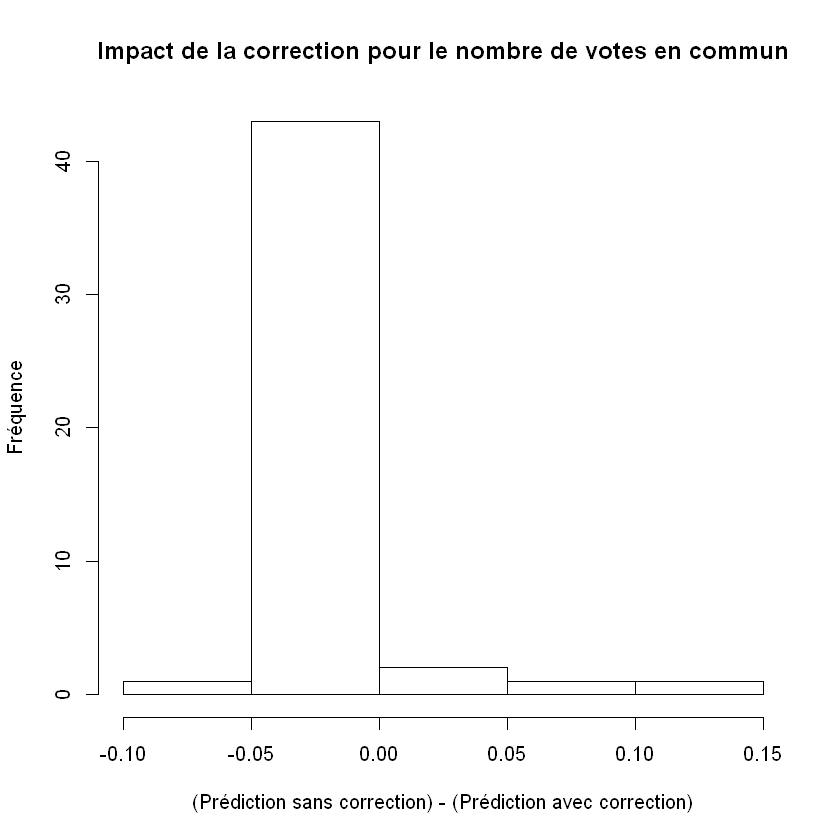

In [27]:
hist(E[!is.na(E)]-EPrim[!is.na(EPrim)],
    main="Impact de la correction pour le nombre de votes en commun",
    ylab="Fréquence",
    xlab="(Prédiction sans correction) - (Prédiction avec correction)")

### Question 4: Calculez l'erreur quadratique moyenne des prédiction de l'approche item-item à la question précédente en la comparant aux valeurs observées.

On compare les valeurs que nous avons estimés à la question précédentes avec les valeurs existantes pour 63 de utilisateurs dans la base de données. On calcul l'erreur quadratique moyenne en considérant au non la correction pour le nombre de votes en commun (parmis les 20 plus proches voisins du film *Star Trek V*). On calcul également la racine de l'erreur quadratique moyenne pour facilité la compréhension (cette racine ne possède pas des unités au carrée, contrairement à l'erreur quadratique moyenne). 


Malgré que l'erreur absolue moyenne ne soit pas une mesure de performance très robuste, elle aide quand même à la compréhension (beaucoup plus facile à interpréter que l'erreur quadratique moyenne). C'est pour cela que nous présentons également cette métrique.

Les vecteurs de prédictions de la question précédente (E et EPrim) contiennent une prédiction pour le 943 utilisateurs de la base de données. Par contre, puisque nous limitons l'analyse aux 20 plus proches voisins de *Star Trek V*, seulement 48 valeurs ne sont pas *NaN*. Parmis ces 48 valeurs, seulement 19 correspondent aux 63 utilisateurs ayant émis un vote pour le film *Star Trek V*. Ainsi, les métriques calculées se basent sur seulement 19 valeurs. 

In [28]:
# Les notes réelles (parmis les 63) pour les valeurs prédites, uniquemment aux positions où la prédiction n'est pas NaN
notereel <- m[,450][!is.na(m[,450])][!is.na(Epredict)]
paste('Toutes les métriques sont basées sur ',toString(length(notereel)), ' valeurs')
cat('\n')

# Les notes prédites qui ne sont pas NaN
notepredict <- Epredict[!is.na(Epredict)]

# Les notes prédites, avec la correction du nombre de votes commmuns, qui ne sont pas NaN
notepredictPrim <- EpredictPrim[!is.na(EpredictPrim)]

('Sans Correction des poids pour le nombre de votes en communs: ')
paste("MSE: ", toString(mse(notepredict, notereel)))
paste("RMSE: ", toString(rmse(notepredict, notereel)))
paste("MAE: ", toString(mae(notepredict, notereel)))
cat('\n')

('Avec Correction des poids pour le nombre de votes en communs: ')
paste("MSE: ", toString(mse(notepredictPrim, notereel)))
paste("RMSE: ", toString(rmse(notepredictPrim, notereel)))
paste("MAE", toString(mae(notepredictPrim, notereel)))

[1] "Toutes les métriques sont basées sur  19  valeurs"

[1] "Sans Correction des poids pour le nombre de votes en communs: "

[1] "MSE:  0.644906143973024"

[1] "RMSE:  0.803060485874522"

[1] "MAE:  0.664528913141385"

[1] "Avec Correction des poids pour le nombre de votes en communs: "

[1] "MSE:  0.642175314358086"

[1] "RMSE:  0.801358418161366"

[1] "MAE 0.66591141299917"

Plusieurs valeurs de gamma (hyperparamètre utilisé pour la correction des poids en considérant le nombre de votes communs entre *Star Trek V* et ses 20 plus proches voisins) ont été testé. Voici les résutats de notre brève *hyperparameter tuning* pour cette correction:

MSE sans correction=0.645

- gamma=2 --> MSE=0.655
- gamma=3 --> MSE=0.654
- gamma=4 --> MSE=0.649
- gamma=5 --> MSE=0.645
- gamma=6 --> MSE=0.642
- gamma=7 --> MSE=0.6407
- gamme=30 --> MSE=0.645


On voit donc que la meilleur valeur pour gamma semble être de 6. Par contre, ce gain de performance est très minime. La correction n'est pas donc pas vraiment efficace dans le contexte du TP.

Lorsque gamma est très grand, nous retrouvons exactement le même MSE que sans correction, puisque le maximum entre le nombre de votes en commun et gamma sera toujours égal à gamma. Ainsi, on vient annuler tout effet de la correction en apposant la même pondération à chacun des 20 voisins!

Dans l'histogramme ci-dessous, nous observons la l'écart entre chacune de nos prédictions et les valeurs réelles. Il est intéressant d'analyser cet histogramme pour voir si en général nous **sur-estimons** ou **sous-estimons** les notes. On observe que l'histogramme n'est pas symétrique par rapport à zéro. En générale, les notes réelles semblent plus élevées que les notes prédites. Ainsi, on pourrait en déduire que **notre algorithme sous-estime (biais vers le bas)** les notes des utilisateurs. Ceci est le genre de *insights* très utile pour développer plusieurs versions de notre algorithme, toujours en tentant d'en améliorer les performances. **63%** (12/19) de nos prédictions se trouvent dans un **intervalle de plus ou moins 1 de la valeur réelle**.

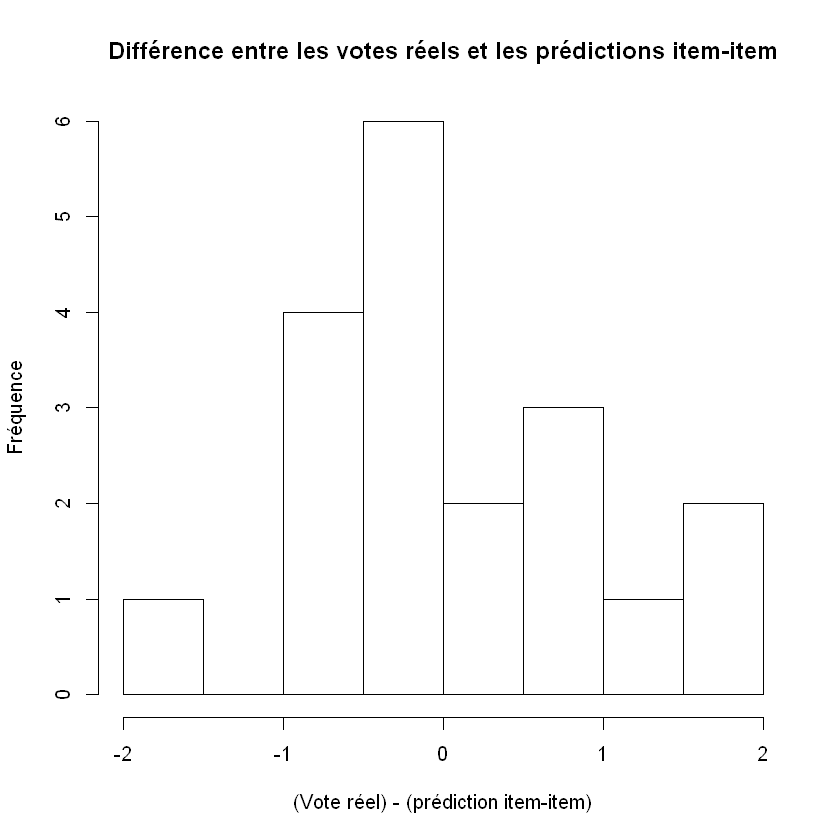

In [29]:
hist(notereel-notepredict,
    main="Différence entre les votes réels et les prédictions item-item",
    ylab="Fréquence",
    xlab="(Vote réel) - (prédiction item-item)")

### Question 5: Utilisez une approche par agglomération (clustering) pour prédire les votes et calculez l'erreur quadratique moyenne. Utilisez 5, 10 et 20 classes.

Voici les étapes pour répondre à cette question:
- On détermine les k *cluster* rassemblant les utilisateurs similaires à l'aide d'une librairie pré-établie de python.
- On détermine les centroïdes de chacun de ces *clusters*.
- Pour chacun des utilisateurs, on détermine selon la distance euclédienne le centroïde le plus près.
- On établie que cet utilisateur devait donc faire partie de ce *cluster*.
- Nos prédictions pour le vote de cette utilisateur pour chacun des films sont les coordonnées cartésiennes du centroïde du *cluster* duquel il fait maintenant partie.

Pour appliqué une méthode de *clustering*, nous devons remplir toutes les valeurs manquantes. Nous avons décidé de remplacer les valeurs manquantes (votes inexistant) par la moyenne des votes déjà attribué à ce film. Ainsi, pour un film ayant actuellement un seul vote dans la base de données (e.g. le film 1682), tous les utilisateurs vont maintenant avoir la valeur de ce vote pour ce film. Nous avons préférés remplir les valeures manquantes par la moyenne sur le film plutôt que la moyenne sur les utilisateurs, car nous trouvions cela plus représentatif. En effet, il est plus probable qu'une opinion à propos d'un film soit généralisé qu'un utilisateur ayant une opinion généralisé de tous les films. 


Comme la question 3 ne portait que sur le film *Star Trek V*, nous avons émis des prédictions (et donc également l'erreur quadratique moyenne) que pour le film *Star Trek V* pour la question 5. L'objectif est de comparé des pommes avec des pommes. Nous avons voulus comparer les performances des deux approches. Par la suite, à la question 7, nous généralisons l'algorithme pour émette des prédictions pour chacun des films. Nous avons simplement voulu, à la question 5, comparer l'algorithme avec celui de la question 3. 

In [43]:
# On change les valeurs manquates par la moyenne de l'item
matNA <- 1*is.na(m)

# Matrice des moyennes (sur les items) pour les valeurs nulles
matComplementaire <- colMean * matNA
matpourkmeans <- m.sparse + matComplementaire

# Partition en 20 clusters
kmean20 <- kmeans(matpourkmeans, center=20)

# Partition en 10 clusters
kmean10 <- kmeans(matpourkmeans, center=10)

# Partition en 5 clusters
kmean5 <- kmeans(matpourkmeans, center=5)

# On extrait la position des centroides de chacun des clusters
centers20 <- kmean20$centers
centers10 <- kmean10$centers
centers5 <- kmean5$centers

#Les centres sont des "pseudo utilisateurs" - Changer la manière de voir le clustering - clustering plus intelligent
("Voici les centroïdes créés en regroupant les utilisateurs en 5 clusters")
centers5

[1] "Voici les centroïdes créés en regroupant les utilisateurs en 5 clusters"

i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,...,i1673,i1674,i1675,i1676,i1677,i1678,i1679,i1680,i1681,i1682
3.270257,2.896708,2.854167,3.329022,3.095567,3.484976,3.543367,3.810003,3.630801,3.761587,...,3,4,3,2,3,1,3,2,3,3
3.878319,1.000000,3.033333,4.000000,4.000000,3.576923,3.798469,4.000000,3.896321,3.831461,...,3,4,3,2,3,1,3,2,3,3
4.158816,3.281621,3.133333,3.955466,3.315564,3.581065,4.202747,4.213277,4.218472,3.913915,...,3,4,3,2,3,1,3,2,3,3
4.319130,3.499320,3.136986,3.556990,3.437400,3.576923,3.906136,4.107150,3.706052,3.806526,...,3,4,3,2,3,1,3,2,3,3
3.862784,3.200289,3.029820,3.532504,3.304777,3.584511,3.774400,3.981309,3.909758,3.832721,...,3,4,3,2,3,1,3,2,3,3


On peut considérer les centroïdes comme étant des ''pseudo-utilisateur''. Chaque valeur pour ce pseudo-utilisateur est la moyenne des votes de utilisateurs qu'il représente. C'est comme si nous réduisions les 943 utilisateurs à seulement *k* utilisateurs.

Lorsqu'un *cluster* possède une coordonnée qui est un entier (et non un nombre décimal), cela veut dire qu'un seul utilisateur parmis tous ceux faisant partie du cluster avait voté pour ce film. Ainsi, la moyenne de tous les utilisateurs faisant partie du cluster pour ce film est la seule valeur disponible. 

In [44]:
# Fonction qui prédit dans quel cluster des utilisateurs sont classifiés. 
# En connaissant le cluster de l'utilisateur, on peut prédire sont vote pour un film
mat_predict_kmeans <- function(object, newdata){
    # On extrait les centroides
    centers <- object$centers
    
    # On détermine le nombre de centroides
    nbx_centers <- nrow(centers)
    
    # On calcule la distance entre chaque utilisateur et les centroides
    dist_mat <- as.matrix(dist(rbind(centers, newdata)))
    dist_mat <- dist_mat[-seq(nbx_centers), seq(nbx_centers)]
    
    # On détermine pour chaque utilisateur le centroide le plus près
    result <- max.col(-dist_mat)
}

Pour chacun des votes prédits, le numéro à sa gauche représente le numéro du *cluster* dans lequel il a été catégorisé. Il est intéressant d'observer si un *cluster* n'est jamais utilisé ou encore si toutes les prédictions tombent dans le même *cluster*.

In [45]:
# Les 63 notes existant réellement pour le film Star Trek V dans la base de données
notereel <- m[,450][!is.na(m[,450])]

i <- mat_predict_kmeans(kmean5, matpourkmeans[which(!is.na(m[,450])),])
note_predict5 <- centers5[i,450]
paste('Voici les notes prédites pour les ',toString(length(note_predict5)), 'utilisateurs ayant émis un vote pour Star Trek V avec 5 clusters')
(note_predict5)

[1] "Voici les notes prédites pour les  63 utilisateurs ayant émis un vote pour Star Trek V avec 5 clusters"

1        3        1        5        4        5        4        5 
2.281746 2.458852 2.281746 2.397233 2.457491 2.397233 2.457491 2.397233 
       5        5        1        5        4        3        3        5 
2.397233 2.397233 2.281746 2.397233 2.457491 2.458852 2.458852 2.397233 
       1        5        5        3        1        5        3        1 
2.281746 2.397233 2.397233 2.458852 2.281746 2.397233 2.458852 2.281746 
       5        3        3        5        4        5        5        4 
2.397233 2.458852 2.458852 2.397233 2.457491 2.397233 2.397233 2.457491 
       5        3        1        2        5        5        5        3 
2.397233 2.458852 2.281746 1.000000 2.397233 2.397233 2.397233 2.458852 
       5        5        4        5        4        5        5        5 
2.397233 2.397233 2.457491 2.397233 2.457491 2.397233 2.397233 2.397233 
       5        5        5        1        5        5        5        1 
2.397233 2.397233 2.397233 2.281746 2.397233 2.397233 2.397233 2.281746 
       4        4        3        1        1        5        5 
2.457491 2.457491 2.458852 2.281746 2.281746 2.397233 2.397233

Observons la distribution (l'histogramme) de la différence entre les notes prédites agglomération et les notes réelles. L'algorithme par agglomération avec 5 *cluster* semble généralement sous-estimer par ses prédictions.

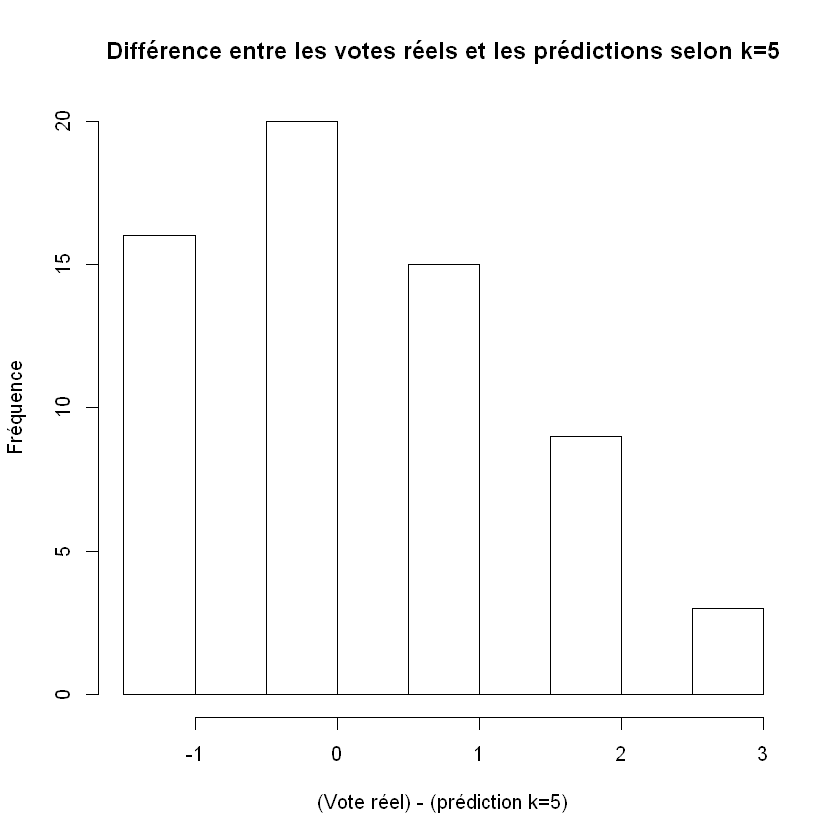

In [46]:
hist(notereel-note_predict5,
    main="Différence entre les votes réels et les prédictions selon k=5",
    xlab="(Vote réel) - (prédiction k=5)",
    ylab="Fréquence")

In [49]:
i <- mat_predict_kmeans(kmean10, matpourkmeans[which(!is.na(m[,450])),])
note_predict10 <- centers10[i,450]
paste('Voici les notes prédites pour les ',toString(length(note_predict10)), 'utilisateurs ayant émis un vote pour Star Trek V avec 10 clusters')
(note_predict10)

[1] "Voici les notes prédites pour les  63 utilisateurs ayant émis un vote pour Star Trek V avec 10 clusters"

7        3        2        6        5        6        8        6 
2.347136 2.461515 3.000000 2.387227 2.487137 2.387227 2.447018 2.387227 
       6        8        1        8        5        3        6        6 
2.387227 2.447018 2.197619 2.447018 2.487137 2.461515 2.387227 2.387227 
       1        6        8        3        7        7        3        4 
2.197619 2.387227 2.447018 2.461515 2.347136 2.347136 2.461515 4.000000 
       6        3        3        6        5        7        6        8 
2.387227 2.461515 2.461515 2.387227 2.487137 2.347136 2.387227 2.447018 
       6        3        1       10        7        6        7        3 
2.387227 2.461515 2.197619 1.000000 2.347136 2.387227 2.347136 2.461515 
       7        6        5        8        8        8        6        6 
2.347136 2.387227 2.487137 2.447018 2.447018 2.447018 2.387227 2.387227 
       8        6        6        7        6        6        6        1 
2.447018 2.387227 2.387227 2.347136 2.387227 2.387227 2.387227 2.197619 
       5        5        3        1        7        6        6 
2.487137 2.487137 2.461515 2.197619 2.347136 2.387227 2.387227

Observons la distribution (l'histogramme) de la différence entre les notes prédites agglomération et les notes réelles. L'algorithme par agglomération avec 10 *cluster* semble généralement sous-estimer par ses prédictions.

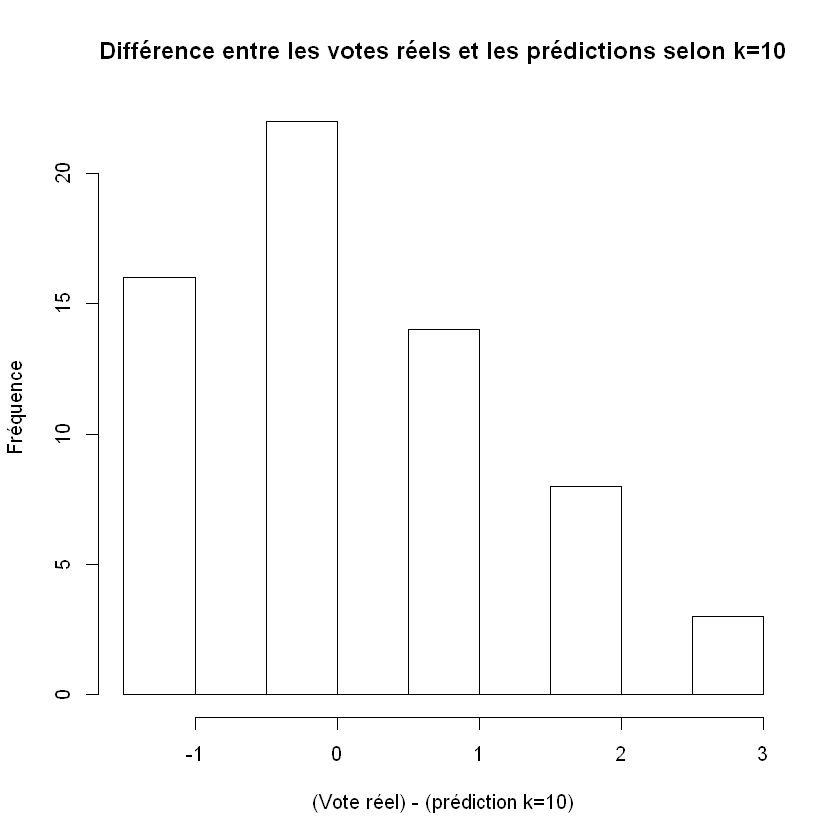

In [50]:
hist(notereel-note_predict10,
    main="Différence entre les votes réels et les prédictions selon k=10",
    xlab="(Vote réel) - (prédiction k=10)",
    ylab="Fréquence")

In [51]:
i <- mat_predict_kmeans(kmean20, matpourkmeans[which(!is.na(m[,450])),])
note_predict20 <- centers20[i,450]

paste('Voici les notes prédites pour les ',toString(length(note_predict20)), 'utilisateurs ayant émis un vote pour Star Trek V avec 20 clusters')
(note_predict20)

[1] "Voici les notes prédites pour les  63 utilisateurs ayant émis un vote pour Star Trek V avec 20 clusters"

12       16       10       15        1        3        5       15 
2.081871 2.854875 3.000000 2.383069 2.410138 2.498697 2.581807 2.383069 
      12       15       11        3       19       18       18        8 
2.081871 2.383069 2.363053 2.498697 2.198413 2.401993 2.401993 2.394444 
      14        8        3       18       12       11       18       20 
2.247354 2.394444 2.498697 2.401993 2.081871 2.363053 2.401993 4.000000 
       3       16        6        8        5       12       15        5 
2.498697 2.854875 2.597884 2.394444 2.581807 2.081871 2.383069 2.581807 
      15       18       11       17       15        7        8       18 
2.383069 2.401993 2.363053 1.000000 2.383069 2.340136 2.394444 2.401993 
       8        3       19        3        1       15       15       15 
2.394444 2.498697 2.198413 2.498697 2.410138 2.383069 2.383069 2.383069 
       3        8       15       12        8        8        8       14 
2.498697 2.394444 2.383069 2.081871 2.394444 2.394444 2.394444 2.247354 
       1        1       18       11        7        3       15 
2.410138 2.410138 2.401993 2.363053 2.340136 2.498697 2.383069

Observons la distribution (l'histogramme) de la différence entre les notes prédites agglomération et les notes réelles. L'algorithme par agglomération avec 20 *cluster* semble généralement sous-estimer par ses prédictions.

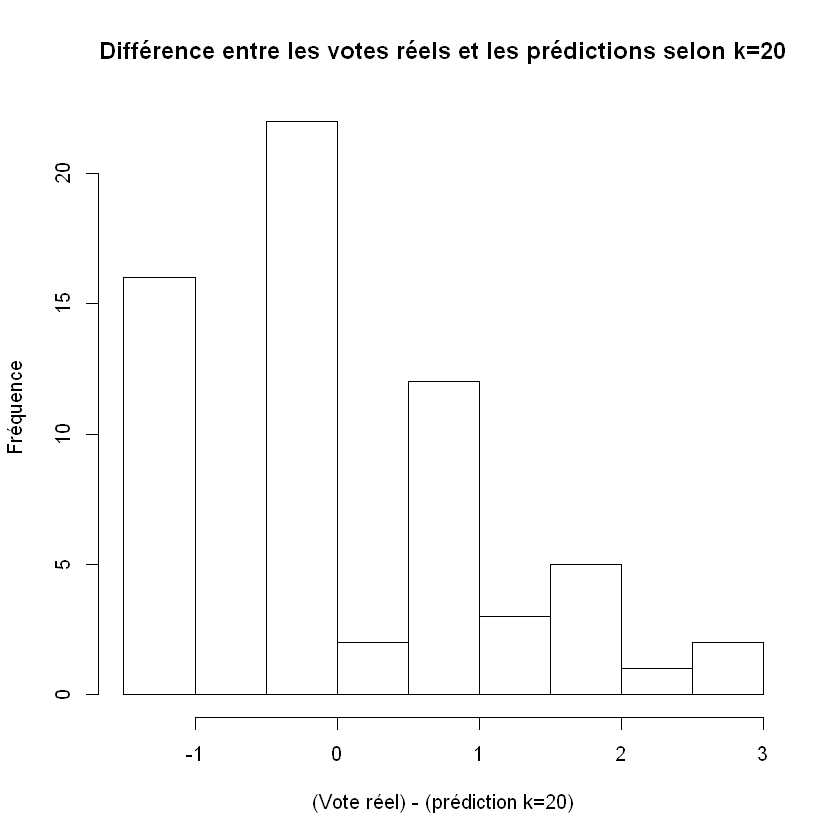

In [52]:
hist(notereel-note_predict20,
    main="Différence entre les votes réels et les prédictions selon k=20",
    xlab="(Vote réel) - (prédiction k=20)",
    ylab="Fréquence")

Tel qu'attendu, plus de nombre de *clusters* considérés augmente, plus la distribution semble tendre vers une distribution normal. Pour avoir un réel aperçu de la performance de k=5, k=10 et k=20, voir ci-dessous le calcul du MSE, RMSE et MAE.

In [53]:
('k=5')
paste("MSE: ", toString(mse(note_predict5, notereel)))
paste("RMSE: ", toString(rmse(note_predict5, notereel)))
paste("MAE: ", toString(mae(note_predict5, notereel)))
cat('\n')

('k=10')
paste("MSE: ", toString(mse(note_predict10, notereel)))
paste("RMSE: ", toString(rmse(note_predict10, notereel)))
paste("MAE: ", toString(mae(note_predict10, notereel)))
cat('\n')

('k=20 ')
paste("MSE: ", toString(mse(note_predict20, notereel)))
paste("RMSE: ", toString(rmse(note_predict20, notereel)))
paste("MAE: ", toString(mae(note_predict20, notereel)))

[1] "k=5"

[1] "MSE:  1.2795660783134"

[1] "RMSE:  1.13117906553888"

[1] "MAE:  0.953376509703969"

[1] "k=10"

[1] "MSE:  1.21765377966736"

[1] "RMSE:  1.10347350655435"

[1] "MAE:  0.911138390812123"

[1] "k=20 "

[1] "MSE:  1.11336719649456"

[1] "RMSE:  1.05516216597003"

[1] "MAE:  0.867467941900206"

On observe donc effectivement une amélioration des métriques lorsque l'on augmente le nombre de *clusters*. Cependant, cette observation est précaire puisqu'elle n'est basée sur les prédictions sur un seul film et sans validation croisée. Nous ne sommes pas capable de capturé la variation des métriques dû à la méthode d'échantillonage. À la question 7, nous allons prédire sur chacun des films, faire de la validation croisé et ensuite calculé l'erreur quadratique moyenne. Ainsi, nous allons mieux pouvoir déterminer le nombre oprimal de *clusters* optimal associé au jeux de données que nous traitons. 

### Question 6: Je suis un nouvel utilisateur. Vous connaissez ma profession, mon sexe et mon âge. Développez un algorithme bayésien pour recommander 10 films sur la base de ces trois catégories.


L'exercice fait en classe avec *Toy Story* est un très bon point de départ pour construire l'algorithme demandé à cette question. La méthodologie est la même, mais au lieu d'avoir seulement deux évidences, nous en avons trois. Ces évidences sont donc la profession, le sexe et l'âge de l'utilisateur.

Le principe de l'approche bayesienne est de regarder dans notre jeux de données les probabilités conditionnelles d'aimer un film basé sur les évidences fournies. 

L'algorithme ce limite à déterminer la propabilité d'aimer un film en particulier selon les trois évidences. Il doit donc être appliqué successivement sur chacun des films. 

Voici la définition des nos évidences et de l'hypothèse:

- E_1: l'emploi de l'utilisateur
- E_2: l'âge de l'utilisateur
- E_3: le sexe de l'utilisateur
- H: aimer le film 


On englobe l'algorithme bayesien dans une fonction (approche fonctionnelle) qui pourrait par la suite être appliquée sur chacun des films. On détermine la probabilité pour chacun des films d'être aimer selon les évidences et on sélectionne les 10 films ayant la plus forte probabilité. Ces 10 films sont nos 10 reccommandations pour ce nouvel utilisateur.

In [54]:
# Créons une fonction qui prend en input: le 'item' du film, la profession, l'âge, le sexe et la matrice joignant u.user et u.item
bayesien_film <- function(item_film, profession, age, sexe, mx){
    
    ############ fonctions utiles
    neg <- function(p) 1-p
    Odds <- function(p) p/(1-p)
    OddsToP <- function(o) o/(1+o)
    ratio.chances <- function(rating.vec, seuil=3) sum(rating.vec > seuil) / sum(rating.vec <= seuil)
      
 
    # Index des users quelconque aimant le film (seuil fixé arbitrairement à 3 sur 5)
    aime <- mx$item.id==item_film & mx$rating>3

    # Index des users quelconque qui n'aiments pas le film
    aime_pas <- mx$item.id==item_film & mx$rating<=3   
    
    # Probabilité initiale (sans aucune évidence) d'aimer le film
    O_h <- ratio.chances(mx[mx$item.id==item_film, 'rating'])
    
    ##### Correction: si personne n'a pas aimer le film, O_h sera de valeur infinie. On lui impose donc manuellement
    ##### une grande valeur pour éviter toute divergence de l'algorithme.
    if(O_h==Inf){
        O_h <-0.999
    }
    
    P_O_h <- OddsToP(O_h)

    # Tableau de fréquence des gens qui aime, séparé par emploi
    aime_job <- table(mx[aime, 'job'])


    # Tableau de fréquence des gens qui n'aime pas, séparé par emploi
    aime_pas_job <- table(mx[aime_pas, 'job'])


    # Tableau de fréquence des gens qui aime, séparé par sexe
    aime_gender <- table(mx[aime, 'gender'])


    # Tableau de fréquence des gens qui n'aime pas, séparé par sexe
    aime_pas_gender <- table(mx[aime_pas, 'gender'])


    # Tableau de fréquence des gens qui aime, séparé par age
    aime_age <- table(mx[aime, 'age'])


    # Tableau de fréquence des gens qui n'aime pas, séparé par age
    aime_pas_age <- table(mx[aime_pas, 'age'])
    
    # P(E_1 | H)
    P_e1h <- ((aime_job)[profession]+1)/(sum(aime_job)+2)
    if (is.na(P_e1h)){
        P_e1h <- 1/(sum(aime_job)+2)
    }

    
    # P(E_1 | ~H)
    P_e1nh <- ((aime_pas_job)[profession]+1)/(sum(aime_pas_job)+2)
    if (is.na(P_e1h)){
        P_e1h <- 1/(sum(aime_pas_job)+2)
    }

    
    # P(E_2 | H)
    P_e2h <- ((aime_age)[toString(age)]+1)/(sum(aime_age)+2)
    if (is.na(P_e2h)){
        P_e2h <- 1/(sum(aime_age)+2)
    }

    
    # P(E_2 | ~H)
    P_e2nh <- ((aime_pas_age)[toString(age)]+1)/(sum(aime_pas_age)+2)
    if (is.na(P_e2nh)){
        P_e2nh <- 1/(sum(aime_pas_age)+2)
    }

    
    # P(E_3 | H)
    P_e3h <- ((aime_gender)[sexe]+1)/(sum(aime_gender)+2)
    if (is.na(P_e3h)){
        P_e3h <- 1/(sum(aime_gender)+2)
    }


    # P(E_3 | ~H)
    P_e3nh <- ((aime_pas_gender)[sexe]+1)/(sum(aime_pas_gender)+2)
    if (is.na(P_e3h)){
        P_e3nh <- 1/(sum(aime_pas_gender)+2)
    }

    
    # On calcule les odds, en supposant l'indépendance de chacune des évidences!!
    reponse_odds <- O_h * P_e1h/P_e1nh * P_e2h/P_e2nh*P_e3h/P_e3nh
    
    # On convertit la répons en probabilité
    reponse_prob <- OddsToP (reponse_odds)
    return(reponse_prob)
    
    
    
}

La question demande de développer un algorithme pour suggérer à un nouvel utilisateur des films, sachant la profession, l'âge et le sexe de cet utilisateur. Nous allons donc sélectionner la profession, l'âge et le sexe d'un des utilisateur dans notre base de données, simplement pour avoir une idée de la performance de notre algorithme. Si nous prenons des évidences complètements aléatoire, nous aurions peu de manière de valider la performance de notre algorithme. Il est simplement pertinent de pouvoir minimalement tester la performance de ce que nous avons créé en comparant avec des données que nous possédons.

On trouvons les utilisateurs avec le plus de votes. En émettant des recommandations pour des utilisateurs ayant un grand nombre
de votes, nous augmentons nos chances que l'utilisateur est déjà émis un vote pour le film que nous lui suggérons. 
Si l'utilisateur a déjà émis un vote pour le film, nous pourrons calculer une précision en regardant si ce vote était de 4 ou plus ou inférieur à 3. 

In [55]:
# On trouve les utilisateurs ayant émis le plus de votes dans la base de données.

# On transforme chaque vote en la valeur 1
votes <- m.sparse
votes[votes!=0] <- 1

# On fait la somme sur les utilisateurs
nb_votes <- rowSums(votes)
top_voteurs <- max.nindex(nb_votes, n=10)

# On regarde les caractérisitques (évidences) de ces top voteurs
('Attributs de top voteurs')
(u.user[top_voteurs,])
('Nombre de votes émis par les top voteurs')
(nb_votes[top_voteurs])

[1] "Attributs de top voteurs"

,id,age,gender,job,zip
405,405,22,F,healthcare,10019
655,655,50,F,healthcare,60657
13,13,47,M,educator,29206
450,450,35,F,educator,11758
276,276,21,M,student,95064
416,416,20,F,student,92626
537,537,36,M,engineer,22902
303,303,19,M,student,14853
234,234,60,M,retired,94702
393,393,19,M,student,83686


[1] "Nombre de votes émis par les top voteurs"

u405 u655  u13 u450 u276 u416 u537 u303 u234 u393 
 737  685  636  540  518  493  490  484  480  448

On sélectionne une combinaison d'évidences E_1, E_2 et E_3 et on applique l'algorithme sur chacun des films. Nous obtiendrons donc la probabilité pour chaque film d'être aimé par un utilisateur respectant ces 3 évidences. Pour cet exemple, nous choisissons l'utilisateur 303 qui est un étudiant, masculin de 19 ans.

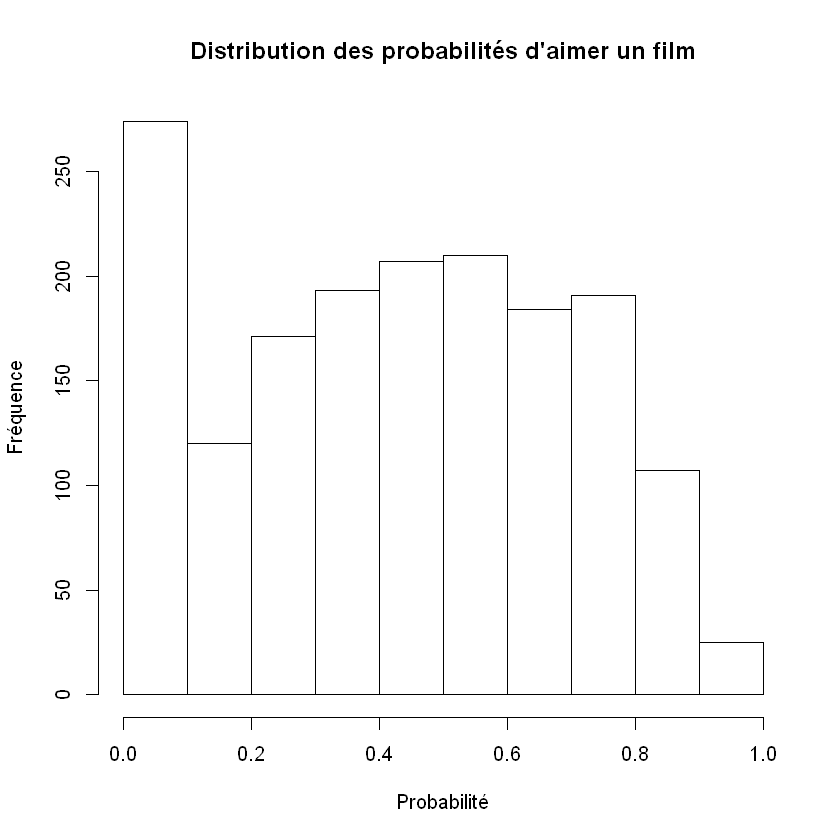

In [56]:
# Détection du nombre de films dans la base de données
nb_films <- dim(u.item)[1]

# Initialisation
films <- seq(1, nb_films)
probs <- rep(0, nb_films)
mx <- merge(u.user, u.data, by=1)

# Sélections d'un utilisateur (On pourrait également itéré sur chaque utilisateur)
user_nb <- 303 

# Extraction des évidences
profession <- u.user[user_nb,]$job
age <- u.user[user_nb,]$age
sexe <- u.user[user_nb,]$gender

# Application de l'algorithme sur chacun des films de la base de données
for (i in films){
    probs[i] <- bayesien_film (i, profession, age, sexe, mx)
}

# Observons la distributions des probabilités d'aimer chacun des films
hist(probs,
    main="Distribution des probabilités d'aimer un film",
    xlab="Probabilité",
    ylab="Fréquence")

On peut maintenant extraire 10 recommandations en prenant les 10 films qui selon notre algorithme ont la plus haute probabilité d'être aimer par l'utilisateur sélectionné. 

À l'inverse, pour tester encore plus notre algorithme, nous pouvons également sortir des films que nous croyons que l'utilisteur ne va pas aimer. Pour ce faire, nous sortons les 300 films avec les probabilités les plus basses d'être aimer. Nous sortons 300 films, et non 10 comme pour les recommandations, car il y a beaucoup de films parmis les pires que l'utilisateur n'a pas regarder. Ceci est normal, puisque comme il y a une faible possibilité que l'utilisateur aime ces films, ils doivent loin de ces intérêts personnels.

Nous avons eu l'idée de tester les ''mauvaises'' recommandations en regardant l'histogramme des probabilité. L'histogramme présente une distribution qui semble normale (en excluant le nombre disroportionné d'instances à 0). Cela veut donc dire que notre algorithme considère que certains films ne devraient pas du tout être aimer par l'utilisateur. Il est donc intéressant d'aller également regardé ces ''mauvaise'' recommandations. Cela permet encore plus de déterminer les capacités et les limitations de l'algorithme. 

In [57]:
# Extractions des 10 meilleures recommandations
top_10_i <- max.nindex (probs, n=10)
titres_rec <- u.item[top_10_i,]$movie.title
('Voici les 10 bonnes recommandations')
print(titres_rec)
('Voici les probabilités associées à ces bonnes recommandations')
(probs[top_10_i])

# Extractions des 10 pires recommandations
worst_10_i <- min.nindex(probs, n=300)
titres_worst <- u.item[worst_10_i,]$movie.title
("Voici les 10 films avec les plus basses probabilités d'être aimé par l'utilisateur")
print(titres_worst)
('Voici les probabilités associées à ces mauvaises recommandations')
(probs[worst_10_i])

[1] "Voici les 10 bonnes recommandations"

 [1] Good Will Hunting (1997)                                           
 [2] City of Lost Children, The (1995)                                  
 [3] Monty Python and the Holy Grail (1974)                             
 [4] Flirting With Disaster (1996)                                      
 [5] Godfather, The (1972)                                              
 [6] Braindead (1992)                                                   
 [7] Nikita (La Femme Nikita) (1990)                                    
 [8] Bound (1996)                                                       
 [9] Shawshank Redemption, The (1994)                                   
[10] Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)


[1] "Voici les probabilités associées à ces bonnes recommandations"

[1] 0.9885508 0.9627298 0.9618777 0.9559348 0.9515799 0.9483428 0.9477019
 [8] 0.9457426 0.9408716 0.9390172

[1] "Voici les 10 films avec les plus basses probabilités d'être aimé par l'utilisateur"

  [1] All Dogs Go to Heaven 2 (1996)                                              
  [2] Theodore Rex (1995)                                                         
  [3] 3 Ninjas: High Noon At Mega Mountain (1998)                                 
  [4] Children of the Corn: The Gathering (1996)                                  
  [5] Amityville 1992: It's About Time (1992)                                     
  [6] Amityville 3-D (1983)                                                       
  [7] Amityville: A New Generation (1993)                                         
  [8] Amityville Curse, The (1990)                                                
  [9] Vampire in Brooklyn (1995)                                                  
 [10] Heavy (1995)                                                                
 [11] Big Squeeze, The (1996)                                                     
 [12] Police Story 4: Project S (Chao ji ji hua) (1993)                           
 [13

[1] "Voici les probabilités associées à ces mauvaises recommandations"

[1] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
  [7] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [13] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [19] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [25] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [31] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [37] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [43] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [49] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [55] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [61] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [67] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [73] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [79] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [85] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [91] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [97] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[103] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[109] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[115] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[121] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[127] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[133] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[139] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[145] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[151] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[157] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[163] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[169] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[175] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[181] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[187] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[193] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[199] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[205] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[211] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[217] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[223] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[229] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[235] 0.00000000 0.03260377 0.03340632 0.03953283 0.04105674 0.04255319
[241] 0.04920255 0.05354355 0.05660377 0.06349621 0.06515740 0.06710152
[247] 0.06769038 0.06794669 0.07184627 0.07525587 0.07594980 0.07670455
[253] 0.07706948 0.07789766 0.07792172 0.07918954 0.08169286 0.08224927
[259] 0.08244949 0.08357764 0.08557295 0.08762454 0.08988764 0.09150454
[265] 0.09370053 0.09492562 0.09530901 0.09644284 0.09652510 0.09682254
[271] 0.09800921 0.09887599 0.09938979 0.09959928 0.10011829 0.10214470
[277] 0.10256410 0.10326904 0.10373444 0.10373444 0.10434315 0.10478919
[283] 0.10709465 0.10838096 0.10876791 0.10878764 0.11101233 0.11382665
[289] 0.11426021 0.11453403 0.11519855 0.11678880 0.11703323 0.11813567
[295] 0.11825595 0.11875535 0.12025073 0.12103304 0.12242899 0.12504557

Regardons si nos recommandantions semblent valides. Nous allons extraire les votes que cet utilisateur à émis pour les recommandations que nous venons de lui suggérer. Bien évidemment, dans le contexte d'un nouvel utilisateur, nous ne pouvons pas faire cette validation. Mais simplement par curiosité, allons voir ces votes. 

In [58]:
# On extrait les votes de cet utilisateur pour les films que nous lui avons recommander
votes_rec <- m.sparse[user_nb, top_10_i]

# On retire les votes nuls (l'utilisateur n'a simplement pas voter pour ce film encore, nous ne pouvons rien en conclure)
votes_rec_non_nul <- votes_rec[votes_rec!=0]
("Voici les votes non-nuls de l'utilisateur pour les films que nous croyons qu'il devrait aimer")
(votes_rec_non_nul)

# On regarde combien de ces votes non-nuls sont de 4 ou plus (seuil arbitraire pour aimer un film)
nb_bonne_rec <- sum(votes_rec_non_nul>3)

# On estime l'accuracy de notre algorithme sur ce user en particulier
accuracy <- nb_bonne_rec/length(votes_rec_non_nul)

paste('Pour cet utilisateur, la précision des bonnes reccomandations est de: ',accuracy)

[1] "Voici les votes non-nuls de l'utilisateur pour les films que nous croyons qu'il devrait aimer"

i919  i168 i1098  i127  i198  i129   i64 
    4     5     4     5     4     5     5

[1] "Pour cet utilisateur, la précision des bonnes reccomandations est de:  1"

Répétons également l'exercice avoir les mauvaises recommandations que nous avons extrait de la méthode bayesienne.

In [59]:
# On extrait les votes de cet utilisateur pour les films que nous lui avons recommander
votes_rec <- m.sparse[user_nb, worst_10_i]

# On retire les votes nuls (l'utilisateur n'a simplement pas voter pour ce film encore, nous ne pouvons rien en conclure)
votes_rec_non_nul <- votes_rec[votes_rec!=0]
("Voici les votes non-nuls de l'utilisateur pour les films que nous croyons qu'il ne devrait pas aimer")
(votes_rec_non_nul)

# On regarde combien de ces votes non-nuls sont de 4 ou plus (seuil arbitraire pour aimer un film)
nb_bonne_rec <- sum(votes_rec_non_nul<4)

# On estime l'accuracy de notre algorithme sur ce user en particulier
accuracy <- nb_bonne_rec/length(votes_rec_non_nul)

paste('Pour cet utilisateur, la précision est des mauvaise recommandations est de: ',accuracy)

[1] "Voici les votes non-nuls de l'utilisateur pour les films que nous croyons qu'il ne devrait pas aimer"

i545 i1092 i1182 i1230 i1270 i1337 i1407 i1508 i1509 i1510 i1089  i801  i540 
    2     1     2     1     1     1     1     1     1     3     1     1     1 
 i759  i783  i391  i397 i1303  i779 i1013 i1090  i998  i158  i586  i368  i245 
    1     2     1     1     3     1     1     1     3     3     2     1     3 
i1232  i765  i252 i1037 i1258  i393  i928 i1224   i63 i1145  i229   i21 i1052 
    3     3     3     3     2     4     3     2     1     2     3     2     2 
i1239 i1222 
    1     3

[1] "Pour cet utilisateur, la précision est des mauvaise recommandations est de:  0.975609756097561"

Pour cet utilisateur, 7 des 10 films que nous lui avons suggérés avaient déjà été visionnés. 7 de ces 7 films ont reçu une note de 4 ou plus. Nous avons donc réussit à lui suggéré des films qu'il aime ainsi que quelques films qu'il n'a pas encore visionné. 


À l'inverse, pour les films que nous croyons que l'utilisateur ne va pas aimer, 41 des 300 films possédaient un vote non-nul. 40 de ces 41 films avaient un notes de 3 et moins. Ainsi, nous avons réussi à prédire avec une précision de 97% des films que l'utilisateur n'aime pas. 


**Important:** il est important de se rappeler que cet utilisateur à contribuer au probabilité fréquentielle que nous avons calculé ultérieurement. Pour réellement tester la performance de notre algorithme, nous aurions du laisser de côté plusieurs utilisateurs (un *leave out*), calculé les probabilités fréquentielles utiliser dans l'algorithme avec le utilisateurs d'entraînement, faire des suggestions sur notre ensemble de *leave out* et ensuite évalué sur cet ensemble de test la performance (précision) de l'algorithme. Cette petite validation n'est pas du tout rigoureuse, mais nous tenions à réellement appliquer l'algorithme développé pour tester son utilité au moins une fois.

### Question 7: Reprenez les calculs de la question 5 avec une validation croisée. Utilisez cette technique pour déterminer le nombre de classes d'agglomération.

Puisqu'à la question 5 nous n'avons calculé l'erreur quadratique moyenne sur un seul film et sans validation croisée, il est important de répéter l'exercie de manière plus rigoureuse pour capter la variation des métriques (e.g. mse) selon les individus sélectionnés dans l'espace échantionnage. Nous allons ainsin pouvoir déterminer le nombre optimal de *clusters* pour obtenir les meilleures prédictions possible. 

In [60]:
# Préparation de la validation croisé
n <- nrow(m.sparse)

# On décide du nombre de fold
Kr <- 10
taille_echantillon <- n %/% Kr

# On assure la répétabilité de nos résultats en imposant la position de départ du générateur de nombre aléatoires
set.seed(5)

# Génération de n nombre aléatoire entre 0 et 1
alea <- runif(n)
rang <- rank(alea)

# On associe à chaque observation (individu) un rang
# On sépare les observations en 10 blocs (les fold)
bloc <- (rang-1) %/% taille_echantillon + 1
bloc <- as.factor(bloc)

On établit les valeurs de *k* (nombre de *clusters*) que l'on désire tester. Puisque les plus gros incréments de performance risques d'être lorsque *k* est petit, nous testons chacun des *k* allant de 1 jusqu'à 110. Par la suite, nous diminuons la densité d'essaies en faisant des bonds de 10 et par la suite des bonds de 100. Le plus grand nombre de *cluster* permis par ce jeu de données est 848, dans lequel cas, chaque cluster ne contient qu'un utilisateur (nous ne pouvons pas aller jusqu'à 943 *clusters*, car nous avons un *leave out*.

In [78]:
clusters <- seq(120)
clusters[110] <- 140
clusters[111] <- 150
clusters[112] <- 160
clusters[113] <- 200
clusters[114] <- 300
clusters[115] <- 350
clusters[116] <- 400
clusters[117] <- 450
clusters[118] <- 550
clusters[119] <- 600
clusters[120] <- 700
clusters[121] <- 848

In [79]:
# On lance la validation croisée

# Initialisation
all.mse <- numeric(0)

# On itère sur le nombre de clusters
for (nbxcenter in clusters) {
    # Initilisation du vecteur de MSE pour cette itération
    vect.mse <- numeric(0)
    
    # Affichage de la progression
    print(nbxcenter)
    Sys.sleep(0.01)
    flush.console()
    
    for (j in 1:Kr){
        
        # Affichage de la progression
        print(j)
        Sys.sleep(0.01)
        flush.console()

        # On crée les clusters
        kmean_model <- kmeans(matpourkmeans[bloc!=j,], center=nbxcenter)
        # On extraire le centroides
        centers_ <- kmean_model$centers
        # On détermine les centroides les plus près
        indice_cluster <- mat_predict_kmeans(kmean_model, matpourkmeans[bloc==j,])
        # On émet nos prédictions pour chaque utilisateur du bloc de validation
        pred <- centers_[indice_cluster,]
        # On extrait les notes réels des utilisateurs du bloc de validation
        notereel = m[bloc==j,]

        # Pour calculé le mse, nous devons trouver les positions dans la matrice de votes qui ne sont pas des NaN.
        ind_not_na <- !is.na(notereel)
        mse <- mse(pred[ind_not_na], notereel[ind_not_na])
        vect.mse <- (cbind(vect.mse, mse))

    }
    all.mse <- rbind(all.mse, vect.mse)
}

# On sauvegarde les résultats pour ne pas avoir à re-exécuter ces résultats
# Permet d'itérer sur plusieurs valeurs de k, ce qui prend beaucoup de temps
write.table(all.mse,file="all_mse.txt")
write.table(clusters,file="clusters.txt")

[1] 1
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 2
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 3
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 4
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 5
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 6
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 7
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 8
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 9
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 10
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 12
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 13
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 14
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 15
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1

[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


Maintenant que pour chaque valeur de k (nombre de *clusters*) nous avons 10 valeurs d'erreur quadratique moyenne, il est possible d'observer la variabilité de cette mesure. En prenant la moyenne des 10 valeurs, nous mitigeons l'effet échantillonale sur l'évaluation de la performance de nos modèles. 

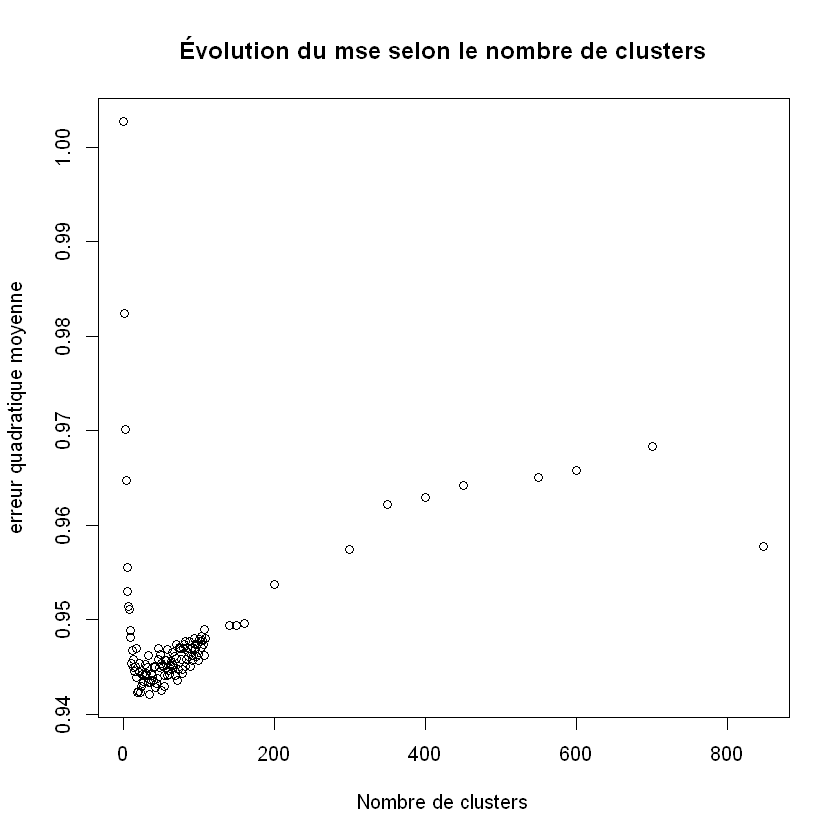

In [80]:
# Au besoin, on importe les résultats en dé-commentant les deux prochaines lignes
#all.mse <- read.table("all_mse.txt",header=TRUE,row.names=1)
#clusters <- read.table("clusters.txt, header=TRUE, row.names=1")

# On crée un point par valeur de k en moyenne sur les 10 folds
moy_mse <- rowMeans(all.mse)

# On afficher un scatter plot de la moyenne des mse par valeur de k
plot(clusters,moy_mse,
     xlab='Nombre de clusters',
     ylab='erreur quadratique moyenne',
     main='Évolution du mse selon le nombre de clusters')

L'erreur quadratique moyenne semble se trouver dans la région de *k* entre 0 et 100. Faisons un agrandissement sur cette région pour mieux voir le minimum globale de ce graphique. On voit très bien dans le graphique ci-dessous qu'il existe une valeur optimale pour *k*, puisque l'erreur quadratique moyenne remonte lorsque *k* devient trop élevé!

[1] "Le nombre optimal de cluster est k= 35 avec une erreur quadratique moyenne de  0.942048904523287 , en utilisant 10 folds"

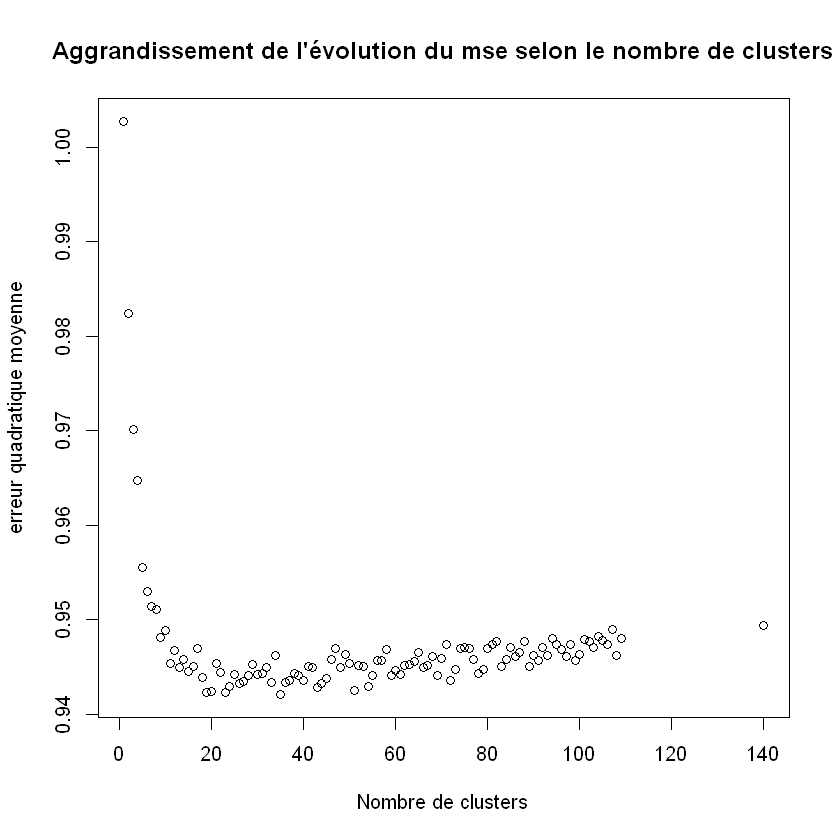

In [100]:
# On affiche seulement la zone d'intérêt
borne <- 110
plot(clusters[1:borne],moy_mse[1:borne],
     xlab='Nombre de clusters',
     ylab='erreur quadratique moyenne',
     main="Aggrandissement de l'évolution du mse selon le nombre de clusters")
paste("Le nombre optimal de cluster est k=",toString(which(moy_mse==min(moy_mse))), "avec une erreur quadratique moyenne de ",toString(moy_mse[35]), ", en utilisant 10 folds")

Nous obtenons donc que la valeur optimale du nombre de clusters est **k=35**, qui nous donne en moyenne (**10 folds**) un mse de **0.94204**.

Il est donc intéressant d'observer la distribution de l'erreur quadratique moyenne sur les 10 *folds* pour k=35. Cela nous permet d'observer la variabilité de la métrique dû aux individus présents dans les échantillons d'entraînement et de validation. Pour encore mieux comprendre la variabilité du mse, nous pouvons également calculé l'écart-type sur les 10 *folds*.

[1] "L'écart-type de cette distribution est de:  0.0684507815414324"

[1] "La moyenne de cette distribution est de:  0.942048904523287"

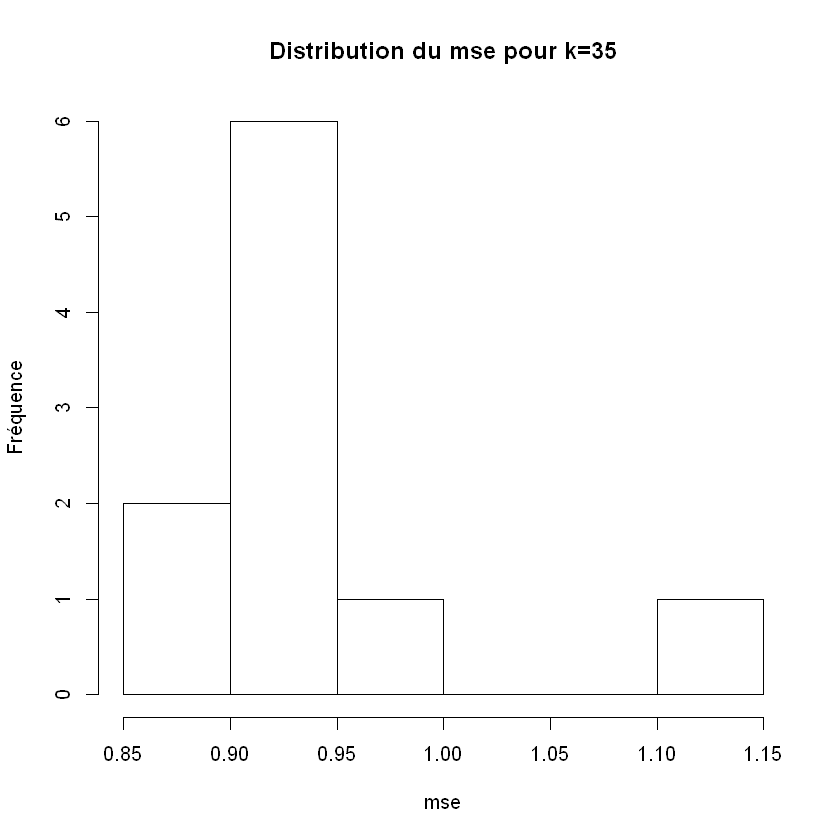

In [138]:
hist(all.mse[35,],
     breaks=8,
     main="Distribution du mse pour k=35",
    xlab="mse",
    ylab="Fréquence")

paste("L'écart-type de cette distribution est de: ",toString(sd(all.mse[35,])))
paste("La moyenne de cette distribution est de: ",toString(mean(all.mse[35,])))